# Using Logistic Regression to Predict Animal Shelter Adoptions

Can we use data about animals in the Austin Animal Center to predict if the animal will be adopted? We will use data cleaning, feature engineering and logistic regression to find out. Raw data comes from the Austin Animal Center database: https://data.austintexas.gov/browse?q=austin%20animal%20center&sortBy=relevance&utf8=✓

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
# Raw data concerning the outcome for each animal
odf = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
# Raw data with details concerning the animal's intake information
idf = pd.read_csv('Austin_Animal_Center_Intakes.csv')

idf = idf[['Animal ID', 'DateTime', 'Intake Type', 'Intake Condition',
          'Age upon Intake']]
df = pd.merge(left = odf, right = idf, how = 'inner', on = 'Animal ID')
df.shape

(137399, 16)

In [3]:
# Renaming columns to differentiate date of intake from date of outcome
df = df.rename(columns = {'DateTime_x': 'outcome date',
                         'DateTime_y': 'intake date'})

# Dropping unneeded columns, missing values and duplicate animal IDs
df = df.drop(['Name', 'MonthYear', 'Outcome Subtype'], axis = 1)
df = df.dropna()
df = df.drop_duplicates(subset = 'Animal ID').reset_index(drop=True)

In [4]:
df['Outcome Type'].value_counts()

Adoption           39899
Transfer           31155
Return to Owner    15115
Euthanasia          7379
Died                 996
Disposal             407
Rto-Adopt            366
Missing               57
Relocate              18
Name: Outcome Type, dtype: int64

As we can see, Adoption is the most common outcome in our data (thankfully). The next step is to generate a new column that reduces these options to a binary breakdown: adopted or not adopted. We may be interested in attempting multiple classification at some point, but we'll keep things simpler for now.

In [5]:
df['is adopted'] = [1 if df.loc[i, 'Outcome Type'] == 'Adoption' else 0 for i in range(len(df['Outcome Type']))]
df = df.drop('Outcome Type', axis = 1)

## Feature Engineering

All the data we have is categorical, meaning a logistic regression algorithm won't know what to do with it. With that in mind, we'll want to create some numeric features where we can, then encode the remaining features.

First up, though, the 'Sex upon Outcome' column actually contains two pieces of information: the sex of the animal and whether it's been spayed or neutered. We'll split this into two columns.

In [6]:
df['Sex upon Outcome'].value_counts()

Neutered Male    31972
Spayed Female    29247
Intact Male      12671
Intact Female    12576
Unknown           8926
Name: Sex upon Outcome, dtype: int64

In [7]:
spayed = []
sex = []
# Creating a list for spayed status and one for sex
for i in range(len(df)):
    if df.loc[i, 'Sex upon Outcome'] == 'Neutered Male' or df.loc[i, 'Sex upon Outcome'] == 'Spayed Female':
        spayed.append('yes')
    elif df.loc[i, 'Sex upon Outcome'] == 'Unknown':
        spayed.append('unknown')
    else:
        spayed.append('no')
        
    if df.loc[i, 'Sex upon Outcome'] == 'Neutered Male' or df.loc[i, 'Sex upon Outcome'] == 'Intact Male':
        sex.append('male')
    elif df.loc[i, 'Sex upon Outcome'] == 'Unknown':
        sex.append('unknown')
    else:
        sex.append('female')

# Adding these lists as columns to the dataframe, then dropping the original columns
df['spayed/neutered'] = spayed
df['sex'] = sex
df = df.drop('Sex upon Outcome', axis = 1)

Alright, now lets turn our attention to some dates. One can imagine that an animal's age could have a big impact on whether it gets adopted. Anecdotally speaking, it can be a lot harder for older cats and dogs to find adopters, as many families would rather adopt a puppy or kitten. 

We'll find the age of every animal, and we'll calculate the length of their stay at the shelter while we're at it.

In [8]:
intake_datetimes= [datetime.strptime(df.loc[i,'intake date'], '%m/%d/%Y %I:%M:%S %p') for i in range(len(df))]
outcome_datetimes= [datetime.strptime(df.loc[i,'outcome date'], '%m/%d/%Y %I:%M:%S %p') for i in range(len(df))]

birthdays = [datetime.strptime(df.loc[i,'Date of Birth'], '%m/%d/%Y') for i in range(len(df))]
intake_age = [intake - birthday for intake, birthday in zip(intake_datetimes, birthdays)]
df['intake age'] = [(delta.days + 1) if delta.seconds > 43199 else delta.days for delta in intake_age]
outcome_age = [outcome - birthday for outcome, birthday in zip(outcome_datetimes, birthdays)]
df['outcome age'] = [(delta.days + 1) if delta.seconds > 43199 else delta.days for delta in outcome_age]

duration = [outcome - intake for outcome, intake in zip(outcome_datetimes, intake_datetimes)]
days = [(delta.days + 1) if delta.seconds > 43199 else delta.days for delta in duration]
df['stay duration'] = days

df = df.drop(['Date of Birth', 'Age upon Outcome', 'outcome date',
              'intake date', 'Age upon Intake'], axis = 1)

The last step before regression is to encode the remaining categorical features. This is the process of converting a column of categorical variables to several columns filled with 1s and 0s, one column for each unique value in the column. The problem with two of our columns is that there are hundreds or even thousands of unique values.

In [9]:
print(df['Breed'].nunique())
df['Color'].nunique()

2451


572

That many columns will be more trouble than it's worth. So, we'll write a quick function to change all values below a certain count threshold to other.

In [10]:
def otherize(df, col, cutoff):
    col_counts = dict(df[col].value_counts())
    new_col = []
    for i in range(len(df)):
        if col_counts[df.loc[i, col]] < cutoff:
            new_col.append('other')
        else:
            new_col.append(df.loc[i, col])
    df[col.lower()] = new_col

In [11]:
otherize(df, 'Breed', 600)
otherize(df, 'Color', 1000)
df = df.drop(['Breed', 'Color'], axis = 1)

In [12]:
df.head()

,Animal ID,Animal Type,Intake Type,Intake Condition,is adopted,spayed/neutered,sex,intake age,outcome age,stay duration,breed,color
0,A798016,Cat,Stray,Normal,0,yes,female,47,125,79,Domestic Shorthair,Black
1,A803571,Cat,Stray,Sick,0,unknown,unknown,1461,1465,4,Domestic Shorthair,Black
2,A803373,Dog,Stray,Normal,0,no,male,366,372,7,other,Black/White
3,A803393,Dog,Owner Surrender,Normal,0,no,male,1827,1833,7,other,Brown/White
4,A803610,Cat,Owner Surrender,Normal,1,yes,female,154,157,3,Domestic Shorthair Mix,other


Now that we've reduced the unique values in these columns, it's time to encode the rest. Luckily, pandas makes this a piece of cake with the 'get_dummies' method. As you can see, we've quickly grown from our original 16 columns all the way up to 73!

In [13]:
df = pd.get_dummies(df, columns = ['Animal Type', 'Intake Type', 'Intake Condition',
                                  'spayed/neutered', 'sex', 'breed', 'color'])
df.shape

(95392, 73)

## Modeling

We've got our data right the way we want it, so it's time to get predicting! The first step is to split the data into training and testing sets. Since the goal is to predict if the animal will be adopted, y will represent adoption status, and X will represent everything else.

In [14]:
X = df.drop(['Animal ID','is adopted'], axis = 1)
y = df['is adopted']
X_train, X_test, y_train, y_test = train_test_split(X,y)

As the goal is to predict a binary feature, logistic regression is a natural choice. Without further ado, we'll fit the regression model to the training data, then measure the model's accuracy against the test data. 

After testing, the model predicted adoption status with 81% accuracy. Not bad for a first pass!

In [15]:
lr = LogisticRegression().fit(X_train, y_train)

score = lr.score(X_test, y_test)
score

/Users/Hunter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8158755451190876

To get a slightly better idea about the model's prediction, we'll use scikit-learn's built-in confusion matrix, then use Seaborn to plot the results.

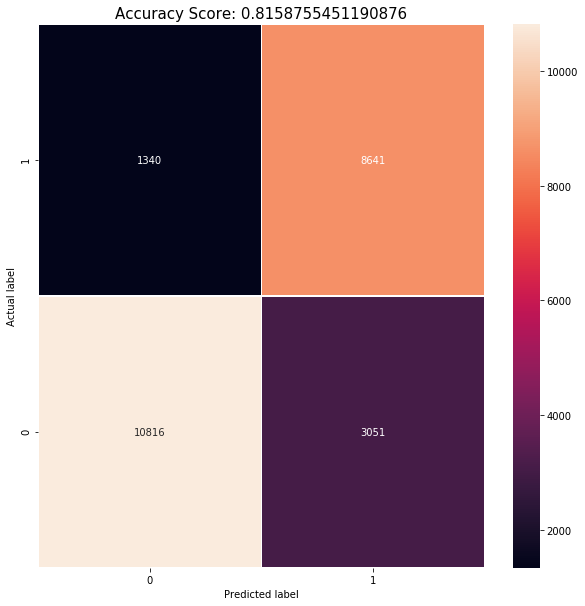

In [21]:
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# re-arranging the matrix for plotting purposes to make for more intuitive viewing
pretty_cm = np.array([cm[1], cm[0]])
plt.figure(figsize=(10,10))
sns.heatmap(pretty_cm, annot=True, fmt="d", linewidths=.5, yticklabels = [1, 0])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {score}', size = 15)
plt.savefig('prediction_accuracy.png')
plt.show()

To sum up, the model correctly predicted 10,711 adoptions and 8,745 non-adoptions. The model also predicted 3,075 false positives and 1,317 false negatives.

# Next Steps

As always, there's much more we can do to attempt to improve the model's predicting power. For one, we could further manipulate the data to make sure the number of animals who are adopted and the number that aren't are equal. This will make things easier on the model, and it would improve the credibility of our accuracy metric as well. 

Further, maybe we were too quick to get rid of the outcome date feature. It's possible that an animal's odds at adoption vary depending on the time of year, or even the time of day.

Beyond this specific prediction, we may also be interested in narrowing our focus to the animals that are adopted and attempt to predict the duration of their stay in the shelter. This kind of information could be enormously helpful to the shelter as it attempts to forecast its capacity.